# Natural Language Processing with Transformers
## Chapter 2 - Text Classification

We finetune a BERT model to perform sentiment classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

In [3]:
# dataset of phrases, labeled with emotions (6 labels)
# NOTE: code in book is out of date - file "emotion" isn't on Dropbox anymore it seems
emotions = load_dataset("dair-ai/emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
emotions["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

## From Datasets to DataFrames

Visualize stuff in Pandas during EDA:

In [5]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
# conver the labels from integers to label names
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head(10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


## EDA - Looking at class distribution, tweet lengths etc.

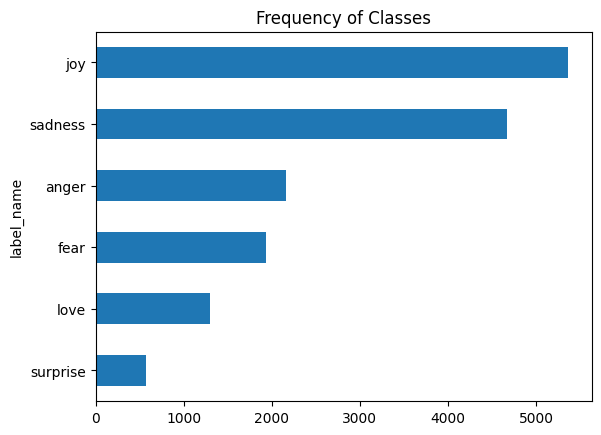

In [7]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

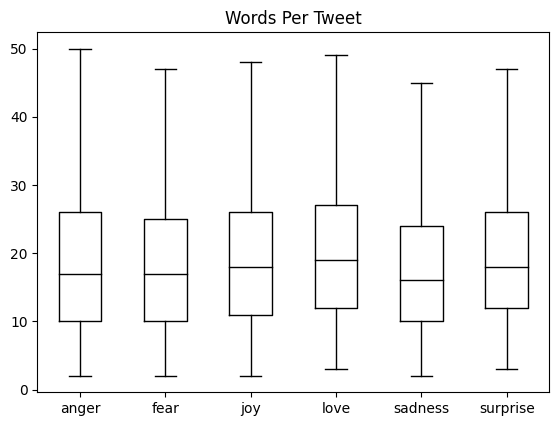

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [9]:
# RESET FORMAT OF DATASET !!

emotions.reset_format()

# Model properties and configuration

From here we are specifying the architecture, checkpoint, tokenizer etc.

We are going to use DistilBERT, with the corresponding correct tokenizer (WordPiece) etc.

In [10]:
# HuggingFace related imports

from transformers import AutoTokenizer

In [11]:
checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
EXAMPLE_TEXT = "Tokenizing text is a core task of NLP."

In [13]:
# check that tokenizing our EXAMPLE_TEXT works
encoded_text = tokenizer(EXAMPLE_TEXT)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [14]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [15]:
# can check the tokenizer properties also

# should be  30522, 512, ['input_ids', 'attention_mask']
print(tokenizer.vocab_size, "---", tokenizer.model_max_length, "---", tokenizer.model_input_names)

# !!!! (model input names are the names of the fields in the dataset that the model expects in its forward pass)

30522 --- 512 --- ['input_ids', 'attention_mask']


## Tokenizing entire Dataset

In [16]:
def tokenize(batch):
    return tokenizer(batch["text"],
                    padding=True,
                    truncation=True)

# check that padding works: see if an attention mask with 0's occurs when different size sentences in a batch
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
# map() on entire dataset, and across all splits in the DatasetDict

emotions_encoded = emotions.map(tokenize,
                               batched=True,
                               batch_size=None)

# default batch_size is 1000; using None means that:
# "our tokenize() function will be applied on the full dataset as a
# single batch. This ensures that the input tensors and attention masks have the same shape globally"

# CHECK: that we now have:
# input_ids
# attention_mask
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [18]:
# We can train a text classifier in 2 ways:
# 1) use the hidden states as features, without modifying the pretrained model, and train a classifier on them
# 2) train the model end to end

## Transformers as Feature Extractors

In [19]:
from transformers import AutoModel
import torch

checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # book forgets to import torch it seems
model = AutoModel.from_pretrained(checkpoint).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
# extract the last hidden states of the model
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

"""COMMENT from book p41:
we place the final hidden state back on the CPU as a NumPy array. The map()
method requires the processing function to return Python or NumPy objects when
we’re using batched inputs."""

'COMMENT from book p41:\nwe place the final hidden state back on the CPU as a NumPy array. The map()\nmethod requires the processing function to return Python or NumPy objects when\nwe’re using batched inputs.'

In [21]:
# model expects tensors as inputs so convert columns to torch format:
#emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [22]:
# get hidden states across all splits
#emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

## Finetuning Transfomers

In [23]:
labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [24]:
#import os
print(torch.cuda.device_count(),"---",torch.cuda.current_device())

1 --- 0


In [25]:
# load a pretrained model (here checkpoint is still DistilBERT from earlier)

from transformers import AutoModelForSequenceClassification

num_labels = len(labels) # see above - labels was obtained in the UMAP classifier bit that i skipped due to Numpy error

# UPDATE after finetuning -- this should have id2label and label2id, see later in notebook
"""model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=checkpoint,
                                                           num_labels=num_labels).to(device)"""

id2label = {i:x for i,x in enumerate(labels)}
label2id = {x:i for i,x in id2label.items()}

print(id2label)
print(label2id)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=checkpoint,
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [26]:
# define the performance metrics
from sklearn.metrics import accuracy_score, f1_score

# compute_metrics receives an EvalPrediction object THIS IS JUST A NAMED TUPLE WITH:
# predictions and label_ids attributes
# compute_metrics must return a dict

# TODO: rename parameter if you can use Typing on their EvalPrediction type instead
def compute_metrics(eval_prediction_object):
    predicted_labels = eval_prediction_object.predictions.argmax(-1) # get the category with largest score, for each input example
    true_labels = eval_prediction_object.label_ids
    
    acc = accuracy_score(y_true=true_labels,
                         y_pred=predicted_labels)
    
    f1 = f1_score(y_true=true_labels,
                  y_pred=predicted_labels,
                  average="weighted")
    
    return {"accuracy": acc, "f1": f1}    

In [27]:
# testing HF notebook login on Kaggle
from huggingface_hub import notebook_login
notebook_login()

In [29]:
# training the model
# using TrainingArguments

from transformers import Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
logging_steps = len( emotions_encoded["train"] ) // batch_size
experiment_finetuned_model_name = f"{checkpoint}-test-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=experiment_finetuned_model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True, # added login details with Access Token so should push to HF
    log_level="error",
    load_best_model_at_end=True, # this is missing in the NLP book AFAICT
    save_strategy="epoch", # if load_best_model need to agree with eval strategy
    report_to="none", # missing in the NLP book, otherwise seems to default to needing WandB key
)

print(device)

cuda


In [30]:
## UPDATE - running in Feb 2024: get numpy errors
# found this on github:
# https://github.com/nlp-with-transformers/notebooks/issues/130
# as temporary workaround
np.object = object

In [31]:
# now we actually train
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

print(f"Starting training of {experiment_finetuned_model_name}")
trainer.train()

Starting training of distilbert-base-uncased-test-finetuned-emotion


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.800300,0.316116,0.906500,0.906635
2,0.248600,0.210192,0.923000,0.922769


TrainOutput(global_step=500, training_loss=0.5244183959960937, metrics={'train_runtime': 144.005, 'train_samples_per_second': 222.214, 'train_steps_per_second': 3.472, 'total_flos': 720342861696000.0, 'train_loss': 0.5244183959960937, 'epoch': 2.0})

In [28]:
# Comments -
# After pushing to HF, noticed that the config.json is missing the mapping between label ids and label names
# This goes in the model definition:

"""print(labels)

id2label = {i:x for i,x in enumerate(labels)}
label2id = {x:i for i,x in id2label.items()}

print(id2label)
print(label2id)


model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=checkpoint,
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id).to(device)
"""
# added/updated model after restarting notebook

# ==> noticed this omission while on the HF page for the created model; you can use the inference API but when I 
# used it on the webpage it was mapping test sentences to e.g. 0,1,2.... rather than meaningful labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [33]:
# Predictions

preds_output = trainer.predict(emotions_encoded["validation"])

# PredictionOutput object contains arrays of predictions and label_ids
# and the metrics that were passed to the Trainer

# For ex: get metrics on the validation set:
preds_output.metrics

{'test_loss': 0.2101915031671524,
 'test_accuracy': 0.923,
 'test_f1': 0.922768838052458,
 'test_runtime': 2.5255,
 'test_samples_per_second': 791.925,
 'test_steps_per_second': 12.671}

In [34]:
#  Also it has the raw predictions for each class. We can decode the predictions
# greedily using np.argmax(). This yields the predicted labels
preds_output.predictions

array([[ 4.429923  , -0.8625019 , -0.939723  , -0.9817619 , -0.8554256 ,
        -1.1580688 ],
       [ 4.30361   , -0.9380252 , -1.5876532 , -0.80384743, -0.13238326,
        -1.1551938 ],
       [-0.8475878 ,  2.368755  ,  2.8659205 , -0.9896114 , -1.8800302 ,
        -1.4209837 ],
       ...,
       [-1.1432507 ,  4.7821307 ,  0.05815414, -1.150457  , -1.6431575 ,
        -0.91071516],
       [-1.4645829 ,  2.7799342 ,  2.8374674 , -1.3933878 , -1.7813293 ,
        -0.9564242 ],
       [-1.3720069 ,  4.5133204 ,  0.02673377, -1.3383232 , -1.5213606 ,
        -0.30909282]], dtype=float32)

In [36]:
preds_output.predictions.shape

# should be 2000 x 6:
# we have passed in 2000 samples from our validation dataset, and
# we have 6 labels, so the predictions are the scores / logits for each of the 6 labels

(2000, 6)

In [37]:
y_preds = np.argmax(preds_output.predictions, axis=1)

y_preds

array([0, 0, 2, ..., 1, 2, 1])

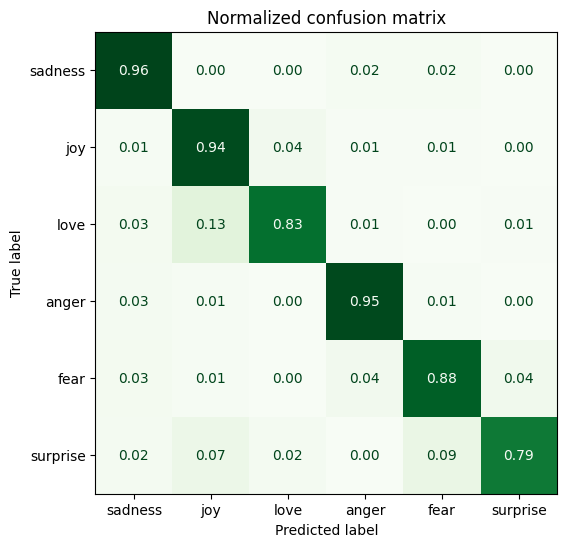

In [44]:
# Plot the confusion matrix:
# Need to use code that was in section (earlier) that wasn't working due to Numpy so reproduced it here:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


# THIS IS NOT EXPLAINED IN BOOK - IT IS STILL USING y_valid VALUE FROM A PREVIOUS
# SECTION, THE HIDDEN STATES OF BERT BEFORE FINE TUNING !?!?
# ------
# THIS IS, I THINK, THE CORRECT THING TO USE - THESE ARE THE CORRECT LABELS FOR THE DATASET:
y_true_labels = preds_output.label_ids

# also confusing variable names - they call "labels" the "LIST OF 6 POSSIBLE LABELS" which
# is only used for annotating the plot - why not call it label_names or something

plot_confusion_matrix(y_preds, y_true_labels, labels)

## Error analysis

Simple idea - we sort the validation samples by the model loss

It says in book, p50:

"when we pass the label during the forward pass, the loss is automatically calculated and returned"

I THINK IT IS CLEARER TO EMPHASISE THAT WE ARE TALKING HERE ABOUT **LOSS AT THE INDIVIDUAL SENTENCE LEVEL**

So in below code I am using this description: "sentence_level_loss"

In [45]:
# function to return sentence_level_loss along with the predicted label
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        
        # this is the predicted label obtained by looking at themaximum logit value 
        pred_label = torch.argmax(output.logits, axis=-1)
        
        # here we look at sentence level loss by calculating the cross entropy
        # between the predicted labels and the true labels
        sentence_level_loss = cross_entropy(output.logits,
                                           batch["label"].to(device),
                                           reduction="none") # AFAICT reduction="none" means to not average over batch
        
        # palce outputs on CPU for compatibility with other dataset cols
        return {"sentence_level_loss": sentence_level_loss.cpu().numpy(),
               "predicted_label": pred_label.cpu().numpy()}
    
    

In [46]:
# map() this to get the the setence level loss for the entire validation dataset

# convert dataset to Pytorch tensors
emotions_encoded.set_format("torch",
                           columns=["input_ids", "attention_mask", "label"])

# get sentence level loss on entire validation dataset
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                   batched=True,
                                                                   batch_size=16) # not sure how these values are chosen??



  0%|          | 0/125 [00:00<?, ?ba/s]

In [50]:
# now we create a pandas df to look at our sentences
emotions_encoded.set_format("pandas")

cols = ["text", "label", "predicted_label", "sentence_level_loss"] # CARE! i changed from just "loss", wasn't very evocative variable name

# !!!!!!!! THEY ARE CALLING THIS df_test FOR SOME REASON BUT IT IS ON THE VALIDATION DATASET
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str) # get label NAMES rather than just as ints
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str) # get label NAMES rather than just as ints

# UPDATE:
# need to do this to be able to read the text on screen
pd.set_option('display.max_colwidth', None)

# now can look at the sentences with highest loss:
df_test.sort_values("sentence_level_loss", ascending=False).head(10)

,text,label,predicted_label,sentence_level_loss
1801,i feel that he was being overshadowed by the supporting characters,love,sadness,5.498598
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.447706
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,5.180357
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,5.137994
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.064904
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,5.008613
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,4.943887
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,joy,fear,4.866012
318,i felt ashamed of these feelings and was scared because i knew that something wrong with me and thought i might be gay,fear,sadness,4.625669
1274,i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate,joy,sadness,4.387591


## Use of the above table

What are we actually looking for here?

First, can identify wrong labels - i.e where we agree with the MODEL rather than the annotator

Second, can look at which parts of the dataset are really causing difficulty

In [51]:
# can do the same for sentences with LOWEST loss
df_test.sort_values("sentence_level_loss", ascending=True).head(10)

,text,label,predicted_label,sentence_level_loss
578,i got to christmas feeling positive about the future and hopeful that hospital admissions were finally behind me,joy,joy,0.015201
669,i am not feeling very joyful today its been a rough day,joy,joy,0.015278
1636,i feel so lucky that my mom is alive and i get to talk to her daily and,joy,joy,0.015342
1418,i am a big believer in the phrase that some people are all style no substance and i feel that if you have nothing worthwhile to say just dont say it,joy,joy,0.015421
1101,im feeling good i increase,joy,joy,0.015495
632,i feel he is an terrific really worth bet,joy,joy,0.015543
1873,i feel practically virtuous this month i have not exceeded my target of only buying things,joy,joy,0.015586
19,i had lunch with an old friend and it was nice but in general im not feeling energetic,joy,joy,0.015596
604,i don t like to use the h word recklessly but i would admit to feeling jolly these days and i have a reason alfie is now the fourth most popular name in the uk well england and wales,joy,joy,0.015708
131,i feel like a graph doesnt show the data accurately enough to be useful,joy,joy,0.015760


## Pushing model to HF and using it to make predictions

Can use `trainer.push_to_hub(commit_message="Training completed!")` with the Trainer API

For prediction we are going to use `pipelines`

In [52]:
from transformers import pipeline

checkpoint = "benjaminzwhite/distilbert-base-uncased-test-finetuned-emotion"

classifier = pipeline("text-classification",
                     model=checkpoint)

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [61]:
# let's try out our model on some new tweets

custom_tweet = "I used Kaggle today and it was really good and awesome wow amazing"

preds = classifier(custom_tweet,
                  top_k=None) # NOTE THIS OPTION ! Didn't know about it

# NOTE: in book p54 they use: return_all_scores=True, but this is deprecated - use top_k=None instead

preds

[{'label': 'joy', 'score': 0.7018792629241943},
 {'label': 'surprise', 'score': 0.23204979300498962},
 {'label': 'fear', 'score': 0.022374169901013374},
 {'label': 'sadness', 'score': 0.01534342486411333},
 {'label': 'anger', 'score': 0.014824509620666504},
 {'label': 'love', 'score': 0.013528932817280293}]

      label     score
0       joy  0.701879
1  surprise  0.232050
2      fear  0.022374
3   sadness  0.015343
4     anger  0.014825
5      love  0.013529


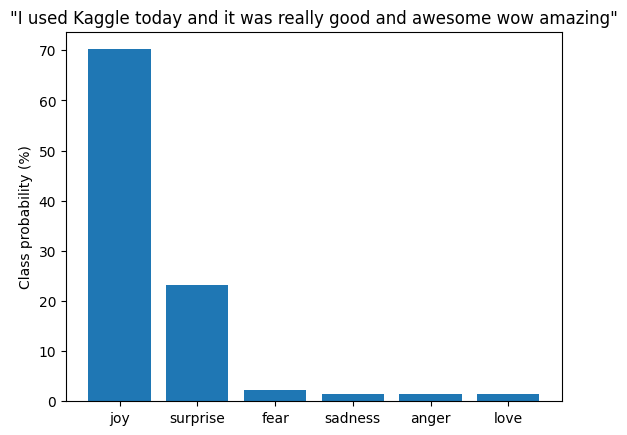

In [64]:
preds_df = pd.DataFrame(preds)
print(preds_df)

# CARE! SINCE UPDATE TO CELL ABOVE / in book p51 it uses return_all_scores=True when it gets preds
# this, it seems, used to return a LIST OF LISTS so they accessed preds[0]

# -> with top_k=None, preds is just:
"""[{'label': 'joy', 'score': 0.7018792629241943},
 {'label': 'surprise', 'score': 0.23204979300498962},
 {'label': 'fear', 'score': 0.022374169901013374},
 {'label': 'sadness', 'score': 0.01534342486411333},
 {'label': 'anger', 'score': 0.014824509620666504},
 {'label': 'love', 'score': 0.013528932817280293}]"""
# So you don't need to do: preds_df = pd.DataFrame(preds[0]) <--- DROP THE [0] COMPARED TO BOOK CODE

plt.bar(preds_df["label"], 100 * preds_df["score"], color='C0')
# HERE ALSO BOOK CODE SEEMS WRONG - IF YOU JUST USE label RATHER THAN preds_df["label"]
# IT WILL DISPLAY LABELS IN ORDER OF APPEARANCE, NOT MATCHED TO THE CORRECT VALUES IN THE PREDS RESULT ???
# might be due to resetting notebook though, I explicity used preds_df["label"] just to be 100% sure

plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()